# softmax回归的从零开始实现
softmax回归是分类问题重要的基础，因此(应当掌握实现softmax回归的细节)。
本节将使用Fashion-MNIST数据集， 并设置数据迭代器的批量大小为256。
Fashion-MNIST数据集包含60000张训练图像和对应Label； 10000张测试图像和对应Label； 10个类别； 每张图像$28\times28$的分辨率

Label Description:
0 T恤（T-shirt/top）
1 裤子（Trouser）
2 套头衫（Pullover）
3 连衣裙（Dress）
4 外套（Coat）
5 凉鞋（Sandal）
6 衬衫（Shirt）
7 运动鞋（Sneaker）
8 包（Bag）
9 靴子（Ankle boot）

# 1. 下载Fashion-MNIST数据集


# 2. 初始化模型参数

和线性回归一样，每个样本都将用固定长度的向量表示。
原始数据集中的每个图像样本的尺寸都是$28\times28$。**展平每个图像，把每个样本看作长度为784**（=$28\times28$）的向量。本例中，把每个像素看作一个特征。
在softmax回归中，网络的输出维度与任务类别一样多。(**数据集有10个类别，所以网络输出维度为10**)。因
此，将权重$\mathbf{w}$ 构造成一个$784\times10$的矩阵， 偏置$\mathbf{b}$将构成一个$1\times10$的行向量。 与线性回归一样，使用正
态分布初始化权重$\mathbf{w}$，偏置$\mathbf{b}$初始化为0。

In [535]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython import display

# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transformations to be applied to the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )

# Download the training and testing datasets
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders for the training and testing datasets
batch_size = 256  # You can adjust the batch size as needed
train_iter = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Now you can use train_iter and test_iter to access the data
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

# Initialize W and b with appropriate shapes and values
num_inputs = 784  # 28 x 28 pixels in Fashion-MNIST images
num_outputs = 10  # 10 classes in Fashion-MNIST
# W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
# b = torch.zeros(num_outputs, requires_grad=True)
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs)).to(device)
b = torch.zeros(num_outputs).to(device)
W.requires_grad_(True)
b.requires_grad_(True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)

# 3. 定义softmax操作
sum 运算符如何沿着张量中的特定维度工作?
1. 给定一个矩阵 $\mathbf{X}$，可以对它的所有元素求和（默认情况下）。
2. 也可以只求同一个轴上的元素，即同一列（轴0）或同一行（轴1）。
如果 $\mathbf{w}$是一个形状为 (2, 3) 的张量，对列进行求和， 则结果将是一个具有形状 (3,) 的向量。（注意：消失了一个轴）
当调用 sum 运算符时，可以指定保持张量的轴数，而不折叠求和的维度。 这将产生一个具有形状 (1, 3) 的二维张量。
实现softmax的三个步骤：
1. 对每个项求幂（使用 exp ）；
2. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
3. 将每一行除以其规范化常数，确保结果的和为1。
回顾表达式：
\begin{align}
softmax(\mathbf{X})_{i j}=\frac{\exp \left(\mathbf{X}_{i j}\right)}{\sum_{k} \exp \left(\mathbf{X}_{i k}\right)}
\end{align}

In [536]:
def softmax(X):
 X_exp = torch.exp(X)
 partition = X_exp.sum(1, keepdim=True)
# print('partition shape:', partition.shape)
 return X_exp / partition # 这里应用了广播机制

对于任何随机输入 $\mathbf{X}$ ， softmax( ) 将每个元素变成一个非负数。 依据概率原理，每行总和为1。

In [537]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X, X_prob, X_prob.sum(1)

(tensor([[ 0.9783,  0.1418, -0.5257, -1.2271, -0.0243],
         [ 0.7870, -0.5553, -0.3650,  0.8736,  0.8897]]),
 tensor([[0.4689, 0.2031, 0.1042, 0.0517, 0.1721],
         [0.2648, 0.0692, 0.0837, 0.2888, 0.2935]]),
 tensor([1., 1.]))

注意，虽然这在数学上看起来是正确的，但我们在代码实现中有点草率。 矩阵中的非常大或非常小的元素在
softmax() 的指数运算中，可能造成数值上溢或下溢，但本例中没有采取措施来防止这点。

# 4. 定义模型
实现softmax回归模型。 下面的代码定义了，根据输入，如何将其通过网络映射到输出。
注意，将数据传递到模型之前，先使用 reshape 函数将每张原始图像展平为向量。例如，将$28\times28$ 的向量
展平为784。

In [538]:
def net(X):
 return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

# 5. 定义损失函数
实现交叉熵（Cross-Entrophy）损失函数，简称**CE Loss**。 它是深度学习中最常见的损失函数。

交叉熵采用真实标签的预测概率的负对数似然。 不要使用for循环来实现其中的迭代计算（低效）， 而是通过
矩阵级运算提高计算效率。

**创建数据样本的估计值 y_hat** ，它包含2个样本在3个类别的预测概率， 以及它们对应的标签 y 。 假设第一
个样本中，第一类是正确的预测； 而在第二个样本中，第三类是正确的预测。 **使用 y 作为 y_hat 中概率的索引**, 选择第一个样本中第一个类的概率，和第二个样本中第三个类的概率。

In [539]:
#第一个样本的正确类别为0，第二个样本的正确类别为2
y = torch.tensor([0, 2])
#第一个样本的关于三个类别的预测概率为[[0.1, 0.3, 0.6]，第二个样本为[0.3, 0.2, 0.5]]
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
#y_hat[[0, 1], y]为两个样本对于各自正确类别的预测概率，注意索引方式
y_hat[[0, 1], y],y_hat[[0, 0], y],y_hat[[1, 0], y]

(tensor([0.1000, 0.5000]), tensor([0.1000, 0.6000]), tensor([0.3000, 0.6000]))

只需一行代码就可以实现交叉熵损失函数。
\begin{align}
\mathcal{L}_{CE}(y, \hat{y}) = -\sum_{i = 1}^{n}(y_i \log (\hat{y}_i))\\
\mathcal{L}_{CE}(y, \hat{y}) = -\log (\hat{y}_y)
\end{align}

# 6. 求分类精度
给定预测概率分布 y_hat ，线性网络必须输出硬预测（hard prediction）， 通常选择预测概率最高的类作为
网络的输出。 例如：电子邮件中将邮件分类为“Primary（主要邮件）”、 “Social（社交邮件）”、“Updates（更
新邮件）”或“Forums（论坛邮件）”。 邮箱软件做分类时可能在内部估计概率，但最终它必须在类中选择一
个。
当预测结果与标签分类 y 一致时，即是正确的。 分类精度即正确预测数量与总预测数量之比。 直接对精度进
行优化很困难（因为精度的计算不可导）， 但精度通常是我们最关心的性能衡量标准，在训练分类器时几乎总
会关注它。
为了计算精度，执行以下操作。
1. 如果 y_hat 是二维矩阵，假定第一个维度对应每个样本，第二个维度存储每个类的预测分数。 使用
argmax 获得每行（第二个维度）中最大值元素的索引，以此作为预测类别。
2. 将预测类别与真实类别 y 的各元素进行比较。 由于等式运算符“ == ”对数据类型很敏感， 因此我们将
y_hat 的数据类型转换为与 y 的数据类型一致。 结果是一个包含0（错）和1（对）的张量。
3. 最后，求和会得到正确预测的数量。

In [540]:
def cross_entropy(y_hat, y):
 #计算每个样本在正确类别上的预测概率，并求log
 return - torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [541]:
def accuracy(y_hat, y): #save
 """计算预测正确的数量"""
# print("y_hat的轴数量:",len(y_hat.shape)," y_hat类别数量:", y_hat.shape[1])
 if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
  y_hat = y_hat.argmax(axis=1)
 cmp = y_hat.type(y.dtype) == y
 return float(cmp.type(y.dtype).sum())

我们将继续使用之前定义的变量 y_hat 和 y 分别作为预测的概率分布和标签。 可以看到，第一个样本的预测
类别是2（该行的最大元素为0.6，索引为2），这与实际标签0不一致。 第二个样本的预测类别是2（该行的最
大元素为0.5，索引为2），这与实际标签2一致。 因此，这两个样本的分类精度率为0.5。

In [542]:
print(y_hat, y)
accuracy(y_hat, y) / len(y)

tensor([[0.1000, 0.3000, 0.6000],
        [0.3000, 0.2000, 0.5000]]) tensor([0, 2])


0.5

同样，对于任意数据迭代器 data_iter 可访问的数据集， 可以评估在任意模型 net 的精度。

In [543]:
def evaluate_accuracy(net, data_iter): #save
 """计算在指定数据集上模型的精度"""
 if isinstance(net, torch.nn.Module):
  net.eval() # 将模型设置为评估模式
 metric = Accumulator(2) # 正确预测数、预测总数
 with torch.no_grad():
  for X, y in data_iter:
   X, y = X.to(device), y.to(device)  # 将数据移到GPU上
   metric.add(accuracy(net(X), y), y.numel())
 return metric[0] / metric[1]

这里定义一个实用程序类 Accumulator ，用于对多个变量进行累加。 在上面的 evaluate_accuracy 函数
中， 我们在( Accumulator 实例中创建了2个变量， 分别用于存储正确预测的数量和预测的总数量)。 当我们
遍历数据集时，两者都将随着时间的推移而累加。

In [544]:
class Accumulator: #save
 """在n个变量上累加"""
 def __init__(self, n):
  self.data = [0.0] * n
 def add(self, *args):
  self.data = [a + float(b) for a, b in zip(self.data, args)]
 def reset(self):
  self.data = [0.0] * len(self.data)
 def __getitem__(self, idx):
  return self.data[idx]

由于我们使用随机权重初始化 net 模型， 因此该模型的精度应接近于随机猜测。 例如在有10个类别情况下的
精度为0.1。

In [545]:
evaluate_accuracy(net, test_iter)

0.121

# 7. 训练
[softmax回归的训练] 过程代码和线性回归非常相似。 在这里，重构训练过程的实现以使其可重复使用。 首
先，定义一个函数来训练一个迭代周期。 请注意， updater 是更新模型参数的常用函数，它接受批量大小作
为参数。 它可以是 sgd 函数，也可以是框架的内置优化函数。

In [546]:
def train_epoch_ch3(net, train_iter, loss, updater): #save
 """训练模型一个迭代周期"""
 # 将模型设置为训练模式
 if isinstance(net, torch.nn.Module):
  net.train()
 # 训练损失总和、训练准确度总和、样本数
 metric = Accumulator(3)
 for X, y in train_iter:
  # 将数据移到GPU上
  X, y = X.to(device), y.to(device)
  # 计算梯度并更新参数
  y_hat = net(X)
  l = loss(y_hat, y)
  if isinstance(updater, torch.optim.Optimizer):
  # 使用PyTorch内置的优化器和损失函数
   updater.zero_grad()
   l.mean().backward()
   updater.step()
  else:
  # 使用定制的优化器和损失函数
   l.sum().backward()
   updater(X.shape[0])
  metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
 # 返回训练损失和训练精度
 return metric[0] / metric[2], metric[1] / metric[2]

在展示训练函数的实现之前，定义一个在动画中绘制数据的实用程序类 Animator ， 它能够简化部分代码

In [547]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
     """A placeholder implementation of set_axes."""
     axes.set_xlabel(xlabel)
     axes.set_ylabel(ylabel)
     axes.set_xscale(xscale)
     axes.set_yscale(yscale)
     axes.set_xlim(xlim)
     axes.set_ylim(ylim)
     axes.legend(legend)

class Animator: #save
 """在动画中绘制数据"""
 def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
        ylim=None, xscale='linear', yscale='linear',
        fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
        figsize=(3.5, 2.5)):
  # 增量地绘制多条线
  if legend is None:
   legend = []
  #d2l.use_svg_display() #Commented out as it's specific to d2l
  self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize) #Replaced d2l.plt with plt
  if nrows * ncols == 1:
   self.axes = [self.axes, ]
  # 使用lambda函数捕获参数
  self.config_axes = lambda: set_axes( #Replaced d2l.set_axes with set_axes
   self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
  self.X, self.Y, self.fmts = None, None, fmts
 def add(self, x, y):
  # 向图表中添加多个数据点
  if not hasattr(y, "__len__"):
   y = [y]
  n = len(y)
  if not hasattr(x, "__len__"):
   x = [x] * n
  if not self.X:
   self.X = [[] for _ in range(n)]
  if not self.Y:
   self.Y = [[] for _ in range(n)]
  for i, (a, b) in enumerate(zip(x, y)):
   if a is not None and b is not None:
    self.X[i].append(a)
    self.Y[i].append(b)
  self.axes[0].cla()
  for x, y, fmt in zip(self.X, self.Y, self.fmts):
   self.axes[0].plot(x, y, fmt)
  self.config_axes()
  display.display(self.fig)
  display.clear_output(wait=True)

接下来实现一个训练函数， 它会在 train_iter 访问到的训练数据集上训练一个模型 net 。 该训练函数将会
运行多个迭代周期（由 num_epochs 指定）。 在每个迭代周期结束时，利用 test_iter 访问到的测试数据集
对模型进行评估。 利用 Animator 类来可视化训练进度。

In [548]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #save
 """训练模型"""
 animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
 legend=['train loss', 'train acc', 'test acc'])
 for epoch in range(num_epochs):
  train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
  test_acc = evaluate_accuracy(net, test_iter)
  animator.add(epoch + 1, train_metrics + (test_acc,))
 train_loss, train_acc = train_metrics
 assert train_loss < 0.5, train_loss
 assert train_acc <= 1 and train_acc > 0.7, train_acc
 assert test_acc <= 1 and test_acc > 0.7, test_acc

作为一个从零开始的实现，使用小批量随机梯度下降来优化模型的损失函数，设置学习率为0.1。

## 以下为个人实现的SGD函数

In [ ]:
import math

def sgd(params, lr=0.01, momentum=0.1, weight_decay=1e-5, beta=0.1,
                         epsilon=1e-8, T_max=400, eta_min=0.0001):
    """
    融合多种优化技术的SGD实现
    
    参数:
    params: 需要优化的参数列表
    lr: 初始学习率(η₀)
    momentum: 动量系数，控制历史梯度的影响程度
    weight_decay: 权重衰减系数，用于L2正则化
    beta: RMSProp的衰减率，控制历史梯度平方的影响
    epsilon: 数值稳定性常数，防止除零错误
    T_max: 余弦退火的周期长度(T)
    eta_min: 最小学习率(η_T)，余弦退火的下限学习率
    
    返回:
    updater: 参数更新函数
    """
    # 初始化动量变量
    v = [torch.zeros_like(param).to(param.device) for param in params]
    
    # 对于RMSProp，初始化梯度平方的移动平均
    s = [torch.zeros_like(param).to(param.device) for param in params]
    
    # 使用列表存储迭代次数，便于在闭包中修改
    iterations = [0]
    
    def updater(batch_size):
        # 更新迭代计数
        iterations[0] += 1
        
        # 学习率衰减: 随训练进行逐渐降低学习率
        # 优势: 前期快速探索参数空间，后期精细调整参数以收敛到更好的局部最小值        
            # 余弦退火学习率调度
            # ------------------------------------
            # 相比传统指数衰减的优势:
            # 1. 训练初期缓慢降低学习率，允许模型充分探索参数空间
            # 2. 训练中期加速降低学习率，促进快速收敛
            # 3. 训练后期再次缓慢降低学习率，实现精细调优
            # 4. 通常能获得更好的泛化性能和更低的最终损失
            # ------------------------------------
        t = iterations[0]
        if t <= T_max:
            # 实现余弦退火公式: η_t = η_min + (η₀-η_min)/2 * (1+cos(πt/T))
            current_lr = eta_min + 0.5 * (lr - eta_min) * (1 + math.cos(math.pi * t / T_max))
        else:
            # 当t>T时，固定学习率为η_min
            current_lr = eta_min
        
        for i, param in enumerate(params):
            if param.grad is None:
                continue
                
            # 权重衰减(L2正则化): 通过惩罚大权重值防止过拟合
            # 优势: 鼓励模型学习更小的权重，提高泛化能力
            grad = param.grad / batch_size + weight_decay * param.data
            
            # RMSProp: 自适应学习率方法
            s[i] = beta * s[i] + (1 - beta) * grad.pow(2)
            
            # RMSProp优势: 
            # 1. 自适应调整每个参数的学习率
            # 2. 对频繁变化的参数使用较小的步长，对不频繁变化的参数使用较大的步长
            # 3. 能够有效处理稀疏梯度和非平稳目标
            
            # 动量更新，但步长由RMSProp和余弦退火共同调整
            v[i] = momentum * v[i] - current_lr * grad / (torch.sqrt(s[i]) + epsilon)
                
            # 应用更新
            param.data += v[i]
            
            # 清零梯度
            param.grad.zero_()
    
    return updater

## 以下为运行结果对比

左侧为原来文件的运行结果，右侧为使用自己实现的SGD函数后的运行结果。可以看出在训练集与测试集上均有提升，同时缓解了过拟合现象。训练曲线平滑，鲁棒性更强。

![Original_result](Original_result.png)
![My_result](My_result.png)

In [ ]:
lr = 0.005

# updater = torch.optim.SGD([W, b], lr=lr)
updater = sgd([W, b], lr = lr, T_max = trainset.__len__() // batch_size * 10 * 0.75, eta_min = 0.0001)

现在，训练模型10个迭代周期。 迭代周期（ num_epochs ）和学习率（ lr ）都是可调节的超参数。 通过更
改它们的值，可以提高模型的分类精度。

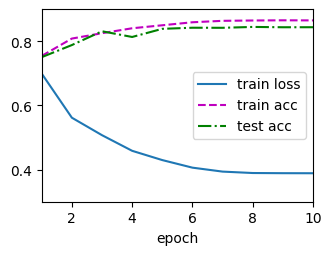

In [550]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

# 8. 预测
现在训练已经完成，我们的模型已经准备好对图像进行分类预测。 给定一系列图像，比较它们的实际标签（文
本输出的第一行）和模型预测（文本输出的第二行）。

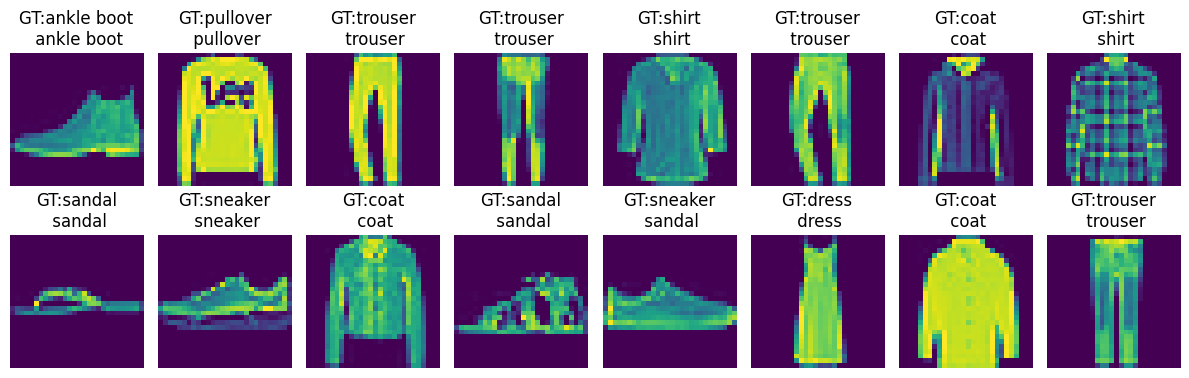

In [551]:
def get_fashion_mnist_labels(labels):
  """Return text labels for the Fashion-MNIST dataset."""
  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [text_labels[int(i)] for i in labels]

def predict_ch3(net, test_iter, n=16): #save
  """预测标签"""
  for X, y in test_iter:
    X, y = X.to(device), y.to(device)  # 将数据移到GPU上
    break
  trues = get_fashion_mnist_labels(y)
  preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
  titles = ["GT:"+true +'\n '+ pred for true, pred in zip(trues, preds)]

  # --- Replacement for d2l.show_images ---
  fig, axes = plt.subplots(2, n // 2, figsize=(12, 4))  # Adjust figsize as needed
  for i in range(n):
      row = i // (n // 2)
      col = i % (n // 2)
      # 显示前将数据移回CPU
      axes[row, col].imshow(X[i].cpu().reshape(28, 28).numpy(), cmap='viridis')
      axes[row, col].set_title(titles[i])
      axes[row, col].axis("off")  # Hide axes ticks and labels
  plt.tight_layout() # Adjust layout for better spacing
  plt.show()
  # --- End of replacement ---

predict_ch3(net, test_iter)